In [ ]:
!pip -q install unidecode chardet

import io, csv, re, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from difflib import get_close_matches
from unidecode import unidecode
import chardet
from google.colab import files


In [ ]:
BASE_DIR = "/content/auditoria_cbo"
OUT_DIR  = os.path.join(BASE_DIR, "outputs")
os.makedirs(OUT_DIR, exist_ok=True)

def norm_txt(s: str) -> str:
    if pd.isna(s): return ""
    s = unidecode(str(s)).lower().strip()
    return re.sub(r"\s+", " ", s)

def norm_cbo(x: str, nd=6) -> str:
    if pd.isna(x): return ""
    d = re.sub(r"\D", "", str(x))
    d = d[:nd]
    return d.zfill(nd) if d else ""

def detect_encoding_sep(file_bytes: bytes):
    det = chardet.detect(file_bytes[:200000])
    enc = (det.get("encoding") or "utf-8")
    if enc.upper() == "ISO-8895-1": enc = "ISO-8859-1"
    # tentar descobrir separador
    try:
        sample = file_bytes[:8000].decode(enc, errors="ignore")
        dialect = csv.Sniffer().sniff(sample, delimiters=";,|\t,")
        sep = dialect.delimiter
    except Exception:
        txt = file_bytes[:8000].decode(enc, errors="ignore")
        counts = {d: txt.count(d) for d in [";", ",", "\t", "|"]}
        sep = max(counts, key=counts.get)
    return enc, sep

def read_csv_bytes(file_bytes: bytes):
    enc, sep = detect_encoding_sep(file_bytes)
    try:
        df = pd.read_csv(io.BytesIO(file_bytes), encoding=enc, sep=sep,
                         dtype=str, engine="python", on_bad_lines="skip")
    except UnicodeDecodeError:
        enc2 = "ISO-8859-1" if enc.upper() != "ISO-8859-1" else "utf-8"
        df = pd.read_csv(io.BytesIO(file_bytes), encoding=enc2, sep=sep,
                         dtype=str, engine="python", on_bad_lines="skip")
        enc = enc2
    return df, enc, sep

def pick_col(df: pd.DataFrame, candidates):
    """encontra coluna por nomes prováveis (ignorando acento/maiúsculas)."""
    by_norm = {norm_txt(c): c for c in df.columns}
    for cand in candidates:
        if cand in by_norm: return by_norm[cand]
        for k, v in by_norm.items():
            if cand in k: return v
    return None


In [ ]:
print("Envie o CSV OFICIAL **CBO (código → título)**. Ex.: 'CBO2002 - Ocupacao.csv'")
up_ref = files.upload()
if not up_ref:
    raise ValueError("Nenhum arquivo de referência CBO enviado.")

ref_name, ref_bytes = next(iter(up_ref.items()))
ref_df, ref_enc, ref_sep = read_csv_bytes(ref_bytes)
print(f"✔️ Referência CBO lida: {ref_name} | enc={ref_enc} | sep={repr(ref_sep)} | shape={ref_df.shape}")

# mapear colunas
col_code = pick_col(ref_df, ["codigo","cod","cbo"])
col_title= pick_col(ref_df, ["ocupacao","titulo","nome"])
if not col_code or not col_title:
    raise ValueError("Não encontrei colunas de CÓDIGO e TÍTULO no arquivo de referência da CBO.")

ref = ref_df.rename(columns={col_code:"_codigo", col_title:"_titulo"})[["_codigo","_titulo"]].copy()
ref["_codigo"] = ref["_codigo"].map(norm_cbo)
ref["_titulo"] = ref["_titulo"].map(norm_txt)
ref = ref[ref["_codigo"]!=""].drop_duplicates()

# dicionários para consulta e sugerir
code2title = {r["_codigo"]: r["_titulo"] for _, r in ref.iterrows()}
titles_list = list(ref["_titulo"].unique())


Envie o CSV OFICIAL **CBO (código → título)**. Ex.: 'CBO2002 - Ocupacao.csv'


Saving CBO2002 - Ocupacao.csv to CBO2002 - Ocupacao (2).csv
✔️ Referência CBO lida: CBO2002 - Ocupacao (2).csv | enc=ISO-8859-1 | sep=';' | shape=(2719, 2)


In [ ]:
print("Envie o seu arquivo **a auditar** (ex.: 'cargos.CSV').")
up_audit = files.upload()
if not up_audit:
    raise ValueError("Nenhum arquivo de auditoria enviado.")

audit_name, audit_bytes = next(iter(up_audit.items()))
df, enc, sep = read_csv_bytes(audit_bytes)
print(f"✔️ Arquivo a auditar: {audit_name} | enc={enc} | sep={repr(sep)} | shape={df.shape}")
display(df.head(5))

# detectar colunas no seu arquivo
col_matricula = pick_col(df, ["matricula","registro","id"])
col_nome      = pick_col(df, ["nome","colaborador","empregado"])
col_cargo     = pick_col(df, ["cargo","funcao","função","descricao do cargo","nome do cargo"])
col_cbo       = pick_col(df, ["cbo","codigo cbo","cod cbo","codigo_cbo","cod_cbo"])
col_estab     = pick_col(df, ["estabelecimento","unidade","filial","local"])
col_ativo     = pick_col(df, ["ativo","situacao","situação","status"])

if not col_cargo or not col_cbo:
    raise ValueError("Não encontrei colunas de 'cargo' e 'cbo' no arquivo a auditar. Me diga os nomes exatos para ajustar.")

wrk = pd.DataFrame({
    "matricula": df[col_matricula] if col_matricula else "",
    "nome":      df[col_nome] if col_nome else "",
    "estabelecimento": df[col_estab] if col_estab else "",
    "ativo":     df[col_ativo] if col_ativo else "S",
    "cargo_informado": df[col_cargo],
    "cbo_informado":   df[col_cbo],
})
wrk["cargo_norm"] = wrk["cargo_informado"].map(norm_txt)
wrk["cbo_norm"]   = wrk["cbo_informado"].map(norm_cbo)
display(wrk.head(5))


Envie o seu arquivo **a auditar** (ex.: 'cargos.CSV').


Saving Cargos e CBOs.xlsx - Plan1.csv to Cargos e CBOs.xlsx - Plan1.csv
✔️ Arquivo a auditar: Cargos e CBOs.xlsx - Plan1.csv | enc=utf-8 | sep=',' | shape=(1170, 3)


,Cargo,CBO 2002,Unnamed: 2
0,ABASTECEDOR,414110,NaN
1,ABASTECEDOR,784205,NaN
2,ADVOGADO JR,241005,NaN
3,ADVOGADO PL,241005,NaN
4,ADVOGADO SR,241005,NaN


,matricula,nome,estabelecimento,ativo,cargo_informado,cbo_informado,cargo_norm,cbo_norm
0,,,,S,ABASTECEDOR,414110,abastecedor,414110
1,,,,S,ABASTECEDOR,784205,abastecedor,784205
2,,,,S,ADVOGADO JR,241005,advogado jr,241005
3,,,,S,ADVOGADO PL,241005,advogado pl,241005
4,,,,S,ADVOGADO SR,241005,advogado sr,241005


✅ Avaliados: 1170
❌ Erros de CBO: 1148 (98.12%)
📈 Gráfico salvo em: /content/auditoria_cbo/outputs/auditoria_cbo_grafico_erros.png
📄 Lista de cargos com descrição incorreta: /content/auditoria_cbo/outputs/cargos_com_descricao_incorreta.csv
🛠️ Sugestões de correção: /content/auditoria_cbo/outputs/sugestoes_de_correcao.csv


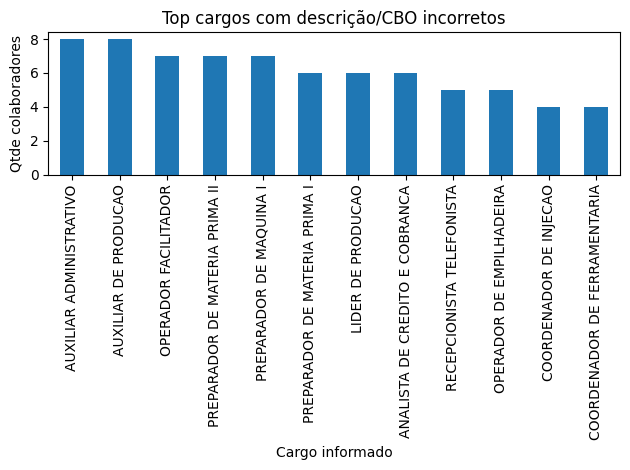

In [ ]:
# regras de validação:
# - CBO válido (6 dígitos)
# - Se CBO existe na tabela oficial:
#     * título oficial do código == cargo declarado? (match por texto normalizado)
# - Se não bate, sugerir:
#     * título oficial do código informado (se existir)
#     * ou top-3 CBOs por "parecido com" o cargo (fuzzy pelos títulos oficiais)

def cbo_valido(cbo: str) -> bool:
    return bool(re.fullmatch(r"\d{6}", cbo))

def suggest_by_title(cargo_norm: str, n=3):
    matches = get_close_matches(cargo_norm, titles_list, n=n, cutoff=0.6)
    sug_codes = [k for k,v in code2title.items() if v in matches]
    return matches, sug_codes[:n]

rows = []
for _, r in wrk.iterrows():
    cbo = r["cbo_norm"]
    cargo = r["cargo_norm"]

    if not cbo_valido(cbo):
        # cbo inválido → só sugerimos por parecido com cargo
        m_titles, m_codes = suggest_by_title(cargo)
        rows.append({**r.to_dict(),
                     "compat_cbo_funcao": False,
                     "motivo": "CBO inválido (formato/dígitos)",
                     "titulo_oficial_do_cbo": "",
                     "cbos_esperados": "|".join(m_codes),
                     "titulos_esperados": "|".join(m_titles)})
        continue

    titulo_oficial = code2title.get(cbo, "")
    if not titulo_oficial:
        # código não consta no referencial
        m_titles, m_codes = suggest_by_title(cargo)
        rows.append({**r.to_dict(),
                     "compat_cbo_funcao": False,
                     "motivo": "CBO não encontrado na tabela oficial",
                     "titulo_oficial_do_cbo": "",
                     "cbos_esperados": "|".join(m_codes),
                     "titulos_esperados": "|".join(m_titles)})
        continue

    # comparar cargo informado x título oficial do código
    if cargo == titulo_oficial:
        rows.append({**r.to_dict(),
                     "compat_cbo_funcao": True,
                     "motivo": "Compatível (exato)",
                     "titulo_oficial_do_cbo": titulo_oficial,
                     "cbos_esperados": cbo,
                     "titulos_esperados": titulo_oficial})
    else:
        # descrição incorreta p/ o código: sugerir o título oficial do próprio código
        # e também alternativas "parecidas" (caso o cargo esteja correto e o código errado)
        m_titles, m_codes = suggest_by_title(cargo)
        sug_codes = [cbo] + [c for c in m_codes if c != cbo]
        sug_titles= [titulo_oficial] + [t for t in m_titles if t != titulo_oficial]
        rows.append({**r.to_dict(),
                     "compat_cbo_funcao": False,
                     "motivo": "Descrição do cargo não corresponde ao título oficial do CBO informado",
                     "titulo_oficial_do_cbo": titulo_oficial,
                     "cbos_esperados": "|".join(sug_codes[:3]),
                     "titulos_esperados": "|".join(sug_titles[:3])})

aud = pd.DataFrame(rows)

# filtrar ativos, se existir
ativos = aud[aud["ativo"].astype(str).str.upper().str.startswith("S")] if "ativo" in aud.columns else aud
erros = ativos[~ativos["compat_cbo_funcao"]].copy()

# Totais + gráfico
total = len(ativos); total_erros = len(erros)
pct = (100*total_erros/total) if total else 0
print(f"✅ Avaliados: {total}")
print(f"❌ Erros de CBO: {total_erros} ({pct:.2f}%)")

plt.figure()
(erros.groupby("cargo_informado")["matricula"].count()
 .sort_values(ascending=False).head(12)
 .plot(kind="bar", title="Top cargos com descrição/CBO incorretos"))
plt.ylabel("Qtde colaboradores")
plt.xlabel("Cargo informado")
plt.tight_layout()
chart_path = os.path.join(OUT_DIR, "auditoria_cbo_grafico_erros.png")
plt.savefig(chart_path)
print("📈 Gráfico salvo em:", chart_path)

# 1) Cargos com descrição incorreta (com códigos esperados)
inc_cols = ["matricula","nome","estabelecimento","cargo_informado","cbo_informado",
            "titulo_oficial_do_cbo","cbos_esperados","titulos_esperados","motivo"]
incompat_path = os.path.join(OUT_DIR, "cargos_com_descricao_incorreta.csv")
erros[inc_cols].to_csv(incompat_path, index=False, encoding="utf-8")
print("📄 Lista de cargos com descrição incorreta:", incompat_path)

# 2) Sugestões de correção (CBOs e títulos oficiais)
def linha_correcao(row):
    # regra simples: se o CBO informado existe na base, sugerimos o TÍTULO OFICIAL dele;
    # além disso, incluímos os CBOs mais prováveis por semelhança do cargo.
    sug_cbos = [c for c in row["cbos_esperados"].split("|") if c]
    sug_tits = [t for t in row["titulos_esperados"].split("|") if t]
    return pd.Series({
        "matricula": row["matricula"],
        "nome": row["nome"],
        "estabelecimento": row["estabelecimento"],
        "cargo_informado": row["cargo_informado"],
        "cbo_informado": row["cbo_informado"],
        "cbo_sugerido": "|".join(sug_cbos),
        "titulo_oficial_sugerido": "|".join(sug_tits)
    })

correcoes = erros.apply(linha_correcao, axis=1)
corr_path = os.path.join(OUT_DIR, "sugestoes_de_correcao.csv")
correcoes.to_csv(corr_path, index=False, encoding="utf-8")
print("🛠️ Sugestões de correção:", corr_path)

# (opcional) baixar agora
# files.download(chart_path); files.download(incompat_path); files.download(corr_path)
